In [46]:
from functools import reduce
import cv2
import matplotlib.pyplot as plt
import numpy as np
from sys import argv
from shapely.geometry import Point, Polygon
import math
import operator
from itertools import product

tablelength = 700
height = tablelength
width = height//2
margin = 20


# filter only four lines


In [47]:
def fourLines(lines):
    strong_lines = np.zeros([4, 1, 2])
    n2 = 0
    for n1 in range(0, len(lines)):
        for rho, theta in lines[n1]:
            if rho < 0:
                rho *= -1
                theta += np.pi
            if n1 == 0:
                strong_lines[n2] = [[rho, theta]]
                n2 += 1
            else:
                closeness_rho = np.isclose(rho, strong_lines[0:n2, 0, 0], atol=150)
                closeness_theta = np.isclose(theta, strong_lines[0:n2, 0, 1], atol=np.pi / 20)
                closeness = np.all([closeness_rho, closeness_theta], axis=0)
                if not any(closeness) and n2 < 4:
                    strong_lines[n2] = [[rho, theta]]
                    n2 += 1
    return strong_lines

In [48]:
def onlygreen(img):
    as_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    low_green_hsv = np.array([40, 52, 50])
    high_green_hsv = np.array([100, 255, 255])
    img_temp = as_hsv.copy()
    unique, counts = np.unique(img_temp.reshape(-1, 3), axis=0, return_counts=True)
    counts = list(enumerate(counts))
    counts.sort(key=lambda x: x[1], reverse=True)
    for c in counts:
        color = unique[c[0]]
        is_green = ((low_green_hsv <= color) & (color <= high_green_hsv)).all()
        if is_green:
            print(color)
            break
#             img_temp[:,:,0], img_temp[:,:,1], img_temp[:,:,2] = color
#             return img_temp
    
    low_green_hsv = np.array([x-2*margin for x in color])
    high_green_hsv = np.array([x+margin for x in color])
    green_mask_hsv = cv2.inRange(as_hsv, low_green_hsv, high_green_hsv)
    green = cv2.bitwise_and(img, img, mask=green_mask_hsv)
    return green, color
    

In [49]:
def findBalls(img, holePoints, rawname):
    img_crl = cv2.medianBlur(img, 5)
    circles = cv2.HoughCircles(img_crl, method=cv2.HOUGH_GRADIENT, dp=1,
                               minDist=15, param1=90, param2=10, minRadius=5, maxRadius=20)
    poly = Polygon(holePoints)
    print(f'holepoints: {holePoints}')
    # Plot the circles
    circles = [c for c in circles[0] if onTable(poly, (int(c[0]), int(c[1])))]
    print(circles)
    plotCircles(img_crl, circles, rawname)
    
    
def find_balls(src):
    final = create_table()

    # warp perspective
    matrix = cv2.getPerspectiveTransform(pts1, pts2)  # getting perspective by 4 points of each image
    transformed = cv2.warpPerspective(src, matrix, (width, height))  # warps perpective to new image

    # apply blur
    transformed_blur = cv2.GaussianBlur(transformed, (5, 5), cv2.BORDER_DEFAULT)  # blur applied
    blur_RGB = cv2.cvtColor(transformed_blur, cv2.COLOR_BGR2RGB)  # rgb version

    # mask
    hsv = cv2.cvtColor(blur_RGB, cv2.COLOR_RGB2HSV)  # convert to hsv
    mask = cv2.inRange(hsv, lower, upper)  # table's mask

    # filter mask
    kernel = np.ones((5, 5), np.uint8)
    mask_closing = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)  # dilate->erode

    # apply threshold
    ret, mask_inv = cv2.threshold(mask_closing, 5, 255, cv2.THRESH_BINARY_INV)  # apply threshold

    # create image with masked objects on table
    masked_objects = cv2.bitwise_and(transformed, transformed, mask=mask_inv)  # masked image

    # find contours and filter them
    ctrs, hierarchy = cv2.findContours(mask_inv, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)  # find contours
    ctrs = filter_ctrs(ctrs)  # filter contours by sizes and shapes

    # draw table+balls
    final = draw_balls(ctrs, radius=8, img=transformed)  # draw all found contours
    final = draw_holes(final)  # draw holes

    return final

In [50]:
def plotCircles(img, circles, rawname):
    start = 0
    fin = len(circles)
    print(f'start:{start}, fin:{fin}')
    for i in circles[start:fin]:
        cv2.circle(img=img, center = (int(i[0]), int(i[1])), radius = int(i[2]), color=(255,0,0), thickness=1)
    cv2.imwrite(rawname + 'Circled.jpeg', img)

In [51]:
def onTable(poly, point):
    testpoint = Point(point)
    output = poly.contains(testpoint)
    # print(f'point: {point} is {output} on polygon')
    return output
    # return True

In [52]:
def fix_boundaries(dst_green, dst_img):
    low_green_hsv = np.array([40, 52, 50])
    high_green_hsv = np.array([100, 255, 255])
    dst_green = cv2.cvtColor(dst_green, cv2.COLOR_BGR2HSV)
    green_mask = cv2.inRange(dst_green, low_green_hsv, high_green_hsv)
    width = len(dst_green[0])
    width_threshold = (2*width)/3
    good = False
    for i in range(10):
        if np.count_nonzero(green_mask[i]) < width_threshold:
            cut_here = i
            while np.count_nonzero(green_mask[cut_here]) < width_threshold:
                cut_here += 1
            dst_green = dst_green[cut_here:,:]
            dst_img = dst_img[cut_here:,:]
            break
            
    height = len(dst_green)
    height_threshold = (2*height)/3
    for i in range(10):
        if np.count_nonzero(green_mask[:,i]) < height_threshold:
            cut_here = i+1
            while np.count_nonzero(green_mask[:,cut_here]) < height_threshold:
                cut_here += 1
            dst_green = dst_green[:,cut_here:]
            dst_img = dst_img[:,cut_here:]
            break
            
    width = len(dst_green[0])
    width_threshold = (2*width)/3
    good = False
    for i in range(10):
        if np.count_nonzero(green_mask[len(dst_green) - i - 1]) < width_threshold:
            cut_here = len(dst_green) - i - 2
            while np.count_nonzero(green_mask[cut_here]) < width_threshold:
                cut_here -= 1
            dst_green = dst_green[:cut_here,:]
            dst_img = dst_img[:cut_here,:]
            break
    
    height = len(dst_green)
    height_threshold = (2*height)/3
    for i in range(10):
        if np.count_nonzero(green_mask[:,len(dst_green[0]) - i - 1]) < height_threshold:
            cut_here = len(dst_green[0]) - i - 2
            while np.count_nonzero(green_mask[:,cut_here]) < height_threshold:
                cut_here -= 1
            dst_green = dst_green[:,:cut_here]
            dst_img = dst_img[:,:cut_here]
            break
    
    return cv2.cvtColor(dst_green, cv2.COLOR_HSV2BGR), dst_img

In [53]:
certain_green = [0, 180, 10]# setting RGB colors to green pool table color, (0,180,10)=certain green
certain_green_bgr = certain_green[::-1]
def create_table():
    # new generated img
    img = np.zeros((tablelength, tablelength//2, 3), dtype=np.uint8)  # create 2D table image
    img[:, :] = certain_green  
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    return img

In [54]:
def draw_holes(input_img, color3=(200, 140, 0)):
    color = (190, 190, 190)  # gray color
    color2 = (120, 120, 120)  # gray color, for circles (holes) on generated img

    img = input_img.copy()  # make a copy of input image

    # borders
    cv2.line(img, (0, 0), (width, 0), color3, 8)  # top
    cv2.line(img, (0, height), (width, height), color3, 8)  # bot
    cv2.line(img, (0, 0), (0, height), color3, 8)  # left
    cv2.line(img, (width, 0), (width, height), color3, 8)  # right

    # adding circles to represent holes on table
    cv2.circle(img, (0, 0), 11, color, -1)  # top right
    cv2.circle(img, (width, 0), 11, color, -1)  # top left
    cv2.circle(img, (0, height), 11, color, -1)  # bot left
    cv2.circle(img, (width, height), 11, color, -1)  # bot right
    cv2.circle(img, (width, int(height / 2)), 8, color, -1)  # mid right
    cv2.circle(img, (0, int(height / 2)), 8, color, -1)  # mid left

    # adding another, smaller circles to the previous ones
    cv2.circle(img, (0, 0), 9, color2, -1)  # top right
    cv2.circle(img, (width, 0), 9, color2, -1)  # top left
    cv2.circle(img, (0, height), 9, color2, -1)  # bot left
    cv2.circle(img, (width, height), 9, color2, -1)  # bot right
    cv2.circle(img, (width, int(height / 2)), 6, color2, -1)  # mid right
    cv2.circle(img, (0, int(height / 2)), 6, color2, -1)  # mid left

    return img

In [55]:
def filter_ctrs(ctrs, img, min_s=120, max_s=1000, alpha=3.445):
    filtered_ctrs = []  # list for filtered contours    
    as_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    for x in range(len(ctrs)):  # for all contours
        bounding_rect = cv2.boundingRect(ctrs[x])
        rot_rect = cv2.minAreaRect(ctrs[x])  # area of rectangle around contour
        w = rot_rect[1][0]  # width of rectangle
        h = rot_rect[1][1]  # height
        area = cv2.contourArea(ctrs[x])  # contour area

        if (area < min_s) or (area > max_s):  # if the contour area is too big/small
            continue  # do nothing
            
        if w > 100 or h > 100:
            continue
        
        img_shape = img.shape
        M = cv2.moments(ctrs[x])
        ccol = int(M['m10'] / M['m00'])  # X pos of contour center
        crow = int(M['m01'] / M['m00'])  # Y pos
        
        if ccol < 10 or ccol > img_shape[1]-10 or crow < 10 or crow > img_shape[0]-10:
            continue
        
        only_rect = np.array(as_hsv[bounding_rect[1]:bounding_rect[1]+bounding_rect[3],
                                     bounding_rect[0]:bounding_rect[0]+bounding_rect[2]]).flatten()
        only_rect = only_rect.reshape((len(only_rect)//3, 3))
                
        variance_rect = np.var(only_rect, axis=0)
        norm_rect = np.linalg.norm(variance_rect)
        if norm_rect < 200:
            continue
        
        # if it failed previous statements then it is most likely a ball
        
        filtered_ctrs.append(ctrs[x])  # add contour to filtered cntrs list

    return filtered_ctrs  # returns filtere contours

In [56]:
ball_radius = 10
def draw_balls(ctrs, white_ball_coors, background=create_table(), radius=ball_radius, size=-1, img=0):
    K = np.ones((3, 3), np.uint8)  # filter
    balls = []
    final = background.copy()  # canvas
    mask = np.zeros(img.shape[:2], np.uint8)  # empty image, same size as 2d generated final output

    for x in range(len(ctrs)):  # for all contours

        # find center of contour
        M = cv2.moments(ctrs[x])
        cX = int(M['m10'] / M['m00'])  # X pos of contour center
        cY = int(M['m01'] / M['m00'])  # Y pos

        # find color average inside contour
        mask[...] = 0  # reset the mask for every ball
        cv2.drawContours(mask, ctrs, x, 255, -1)  # draws mask for each contour
        mask = cv2.erode(mask, K, iterations=3)  # erode mask several times to filter green color around balls contours

        # balls design:
        
        # circle to represent snooker ball
        if (cX, cY) == white_ball_coors:
            final = cv2.circle(final,  # img to draw on
                           (cX, cY),  # position on img
                           radius,  # radius of circle - size of drawn snooker ball
                           (255,255,255),
                           # color mean of each contour-color of each ball (src_img=transformed img)
                           size)  # -1 to fill ball with color
            
        else:
            final = cv2.circle(final,  # img to draw on
                           (cX, cY),  # position on img
                           radius,  # radius of circle - size of drawn snooker ball
                           cv2.mean(img, mask),
                           # color mean of each contour-color of each ball (src_img=transformed img)
                           size)  # -1 to fill ball with color

        # add black color around the drawn ball (for cosmetics)
        final = cv2.circle(final, (cX, cY), radius, 0, 1)

        # small circle for light reflection
        final = cv2.circle(final, (cX - 2, cY - 2), 2, (255, 255, 255), -1)
        if (cX, cY) != white_ball_coors:
            balls.append([cX, cY])

    
    return final, balls

In [57]:
def find_ctrs_color(ctrs, input_img):
    K = np.ones((3, 3), np.uint8)  # filter
    output_img = input_img.copy()  # np.zeros(input_img.shape,np.uint8) # empty img
    gray = cv2.cvtColor(input_img, cv2.COLOR_BGR2GRAY)  # gray version
    mask = np.zeros(gray.shape, np.uint8)  # empty mask
    brightest_ball_coors = None
    brightest_ball_color = np.array((0,0,0))

    for i in range(len(ctrs)):  # for all contours

        # find center of contour
        M = cv2.moments(ctrs[i])
        cX = int(M['m10'] / M['m00'])  # X pos of contour center
        cY = int(M['m01'] / M['m00'])  # Y pos

        mask[...] = 0  # reset the mask for every ball

        cv2.drawContours(mask, ctrs, i, 255,
                         -1)  # draws the mask of current contour (every ball is getting masked each iteration)

        mask = cv2.erode(mask, K, iterations=3)  # erode mask to filter green color around the balls contours
        
        
        color = np.array(cv2.mean(input_img, mask))
        comp = color[:3] > brightest_ball_color
#         print(f'best so far {brightest_ball_color}, new one is {color}')
#         print(comp)
#         print(comp.sum())
        brighter = comp.sum() > 1
        
        if brighter:
            brightest_ball_color = color[:3]
            brightest_ball_coors = (cX, cY)
    
            
        output_img = cv2.circle(output_img,  # img to draw on
                            (cX, cY),  # position on img
                            20,  # radius of circle - size of drawn snooker ball
                            color,
                            # color mean of each contour-color of each ball (src_img=transformed img)
                            -1)  # -1 to fill ball with color            
            
            
    output_img = cv2.circle(output_img,  # img to draw on
                            brightest_ball_coors,  # position on img
                            20,  # radius of circle - size of drawn snooker ball
                            (255,0,0), # color mean of each contour-color of each ball (src_img=transformed img)
                            3)  # -1 to fill ball with color
    
    return output_img, brightest_ball_coors

In [58]:
def draw_rectangles(ctrs, img):
    output = img.copy()

    for i in range(len(ctrs)):
        M = cv2.moments(ctrs[i])  # moments
        rot_rect = cv2.minAreaRect(ctrs[i])
        w = rot_rect[1][0]  # width
        h = rot_rect[1][1]  # height

        box = np.int64(cv2.boxPoints(rot_rect))
        cv2.drawContours(output, [box], 0, (255, 0, 0), 2)  # draws box

    return output

In [59]:
def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / np.linalg.norm(vector)

def angle_between(v1, v2):
    """ Returns the angle in radians between vectors 'v1' and 'v2'::

            >>> angle_between((1, 0, 0), (0, 1, 0))
            1.5707963267948966
            >>> angle_between((1, 0, 0), (1, 0, 0))
            0.0
            >>> angle_between((1, 0, 0), (-1, 0, 0))
            3.141592653589793
    """
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.rad2deg(np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0)))

[ 79 255 211]


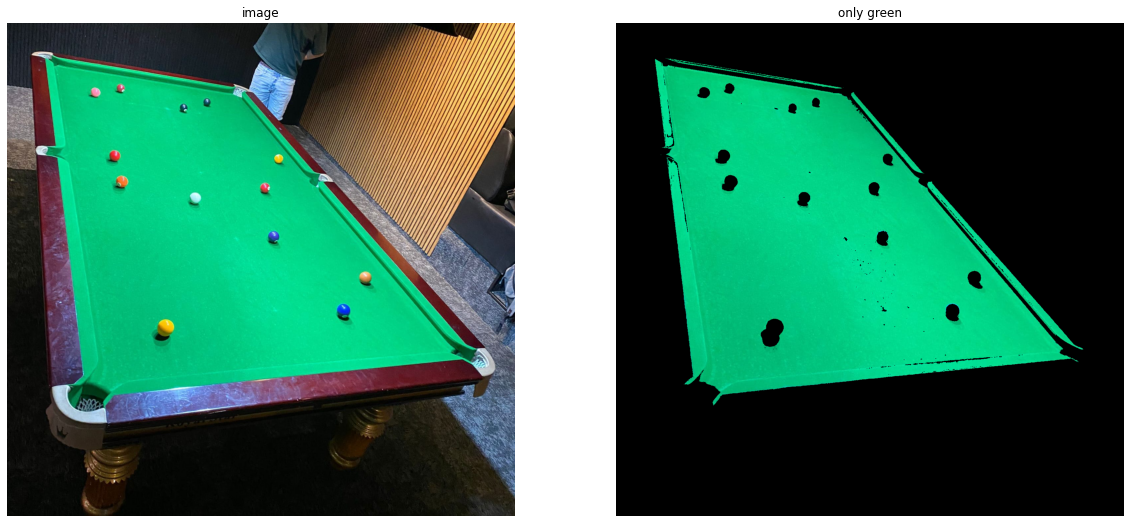

In [60]:
picname = "ICBV231-11-test-image6.jpg" #insert image file name here
img = cv2.imread(picname)
rgbimg = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
rawname = picname.split('.')[0]
greenimg, table_green = onlygreen(img)

# plt.imshow(cv2.cvtColor(greenimg, cv2.COLOR_BGR2RGB))
# plt.show()
graygreen = cv2.cvtColor(greenimg, cv2.COLOR_BGR2GRAY)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
edges = cv2.Canny(graygreen, 50, 150, apertureSize=3)
lines = cv2.HoughLines(edges, 1, np.pi / 180, 100)
stronglines = fourLines(lines)


plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(rgbimg)
plt.title('image')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(cv2.cvtColor(greenimg, cv2.COLOR_BGR2RGB))
plt.title('only green')
plt.axis('off')
plt.show()
#cv2.imwrite(rawname + '1.jpg', greenimg)


(-0.5, 349.5, 669.5, -0.5)

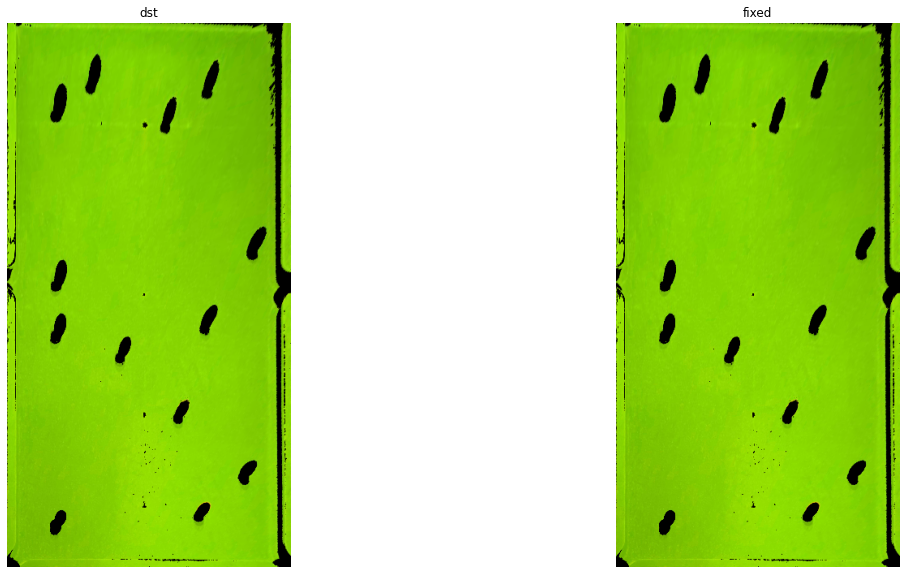

In [61]:
linescoefs = []

for r_theta in stronglines:
    arr = np.array(r_theta[0], dtype=np.float64)
    r, theta = arr
    # Stores the value of cos(theta) in a
    a = np.cos(theta)
    # Stores the value of sin(theta) in b
    b = np.sin(theta)
    # x0 stores the value rcos(theta)
    x0 = a * r
    # y0 stores the value rsin(theta)
    y0 = b * r
    # x1 stores the rounded off value of (rcos(theta)-1000sin(theta))
    x1 = int(x0 + 2000 * (-b))
    # y1 stores the rounded off value of (rsin(theta)+1000cos(theta))
    y1 = int(y0 + 2000 * (a))
    # x2 stores the rounded off value of (rcos(theta)+1000sin(theta))
    x2 = int(x0 - 2000 * (-b))
    # y2 stores the rounded off value of (rsin(theta)-1000cos(theta))
    y2 = int(y0 - 2000 * (a))

    m = (y2 - y1) / (x2 - x1) if x2 != x1 else None
    n = y2 - m * x2 if m else x1
    linescoefs.append((m, n))
    cv2.line(img, (x1, y1), (x2, y2), (0, 0, 255), 2) #drawing 4 lines - to visualize


ispoints = []

for i, coefs1 in enumerate(linescoefs):
    m1, n1 = coefs1
    for j, coefs2 in enumerate(linescoefs[i+1:]):
        m2, n2 = coefs2
        if m1==m2:
            continue
        if m1 == None:
            if m2 == None:
                continue
            else:
                m1 = m2
                tmp = n1
                n1 = n2
                n2 = tmp
                m2 = None
        if m2 == None:
            col = n2
            row = int(m1*col+n1)
        else:
            col = int((n1-n2)/(m2-m1))
            row = int(m1*col+n1)
        if -1 < col < img.shape[1] and -1 < row < img.shape[0]:
            ispoints.append([col, row])

center = tuple(map(operator.truediv, reduce(lambda x, y: map(operator.add, x, y), ispoints), [len(ispoints)] * 2))
holepoints = sorted(ispoints, key=lambda coord: (-135 - math.degrees(math.atan2(*tuple(map(operator.sub, coord, center))[::-1]))) % 360)


cv2.imwrite(rawname + 'Lined.jpeg', img)

# Coordinates that you want to Perspective Transform
pt1 = np.float32(holepoints)
# Size of the Transformed Image
tablesize = (tablelength//2, tablelength)
pt2 = np.float32([[0, tablelength], [tablelength//2, tablelength], [tablelength//2, 0], [0, 0]])

for val in pt1:
    cv2.circle(img, (int(val[0]), int(val[1])), 10, (255, 0, 0), -1) #drawing 4 points to visualize
cv2.imwrite(rawname + 'Pts.jpeg', img)

M = cv2.getPerspectiveTransform(pt1, pt2)
dst_green = cv2.warpPerspective(greenimg, M, tablesize)
dst_img = cv2.warpPerspective(rgbimg, M, tablesize)


long_side_middle = dst_img[325:375,0]
variance_long_side = np.var(long_side_middle, axis=0)
norm_longside = np.linalg.norm(variance_long_side)
short_side_middle = dst_img[0, 150:200]
variance_short_side = np.var(short_side_middle, axis=0)
norm_shortside = np.linalg.norm(variance_short_side)


if (norm_shortside > norm_longside):
#     print('turning it around')
    holepoints.append(holepoints.pop(0))
    pt1 = np.float32(holepoints)
    M = cv2.getPerspectiveTransform(pt1, pt2)
    dst_green = cv2.warpPerspective(greenimg, M, tablesize)
    dst_img = cv2.warpPerspective(rgbimg, M, tablesize)
    
dst_green, dst_img = fix_boundaries(dst_green, dst_img)
    
   
cv2.imwrite(rawname + 'Table.jpg',  cv2.cvtColor(dst_img, cv2.COLOR_BGR2RGB))
#cv2.imwrite(rawname + '2.jpg', dst_green)

# plt.imshow(cv2.cvtColor(fix_boundaries(dst_green), cv2.COLOR_BGR2RGB))
# plt.show()

plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(dst_green)
plt.title('dst')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(dst_green)
plt.title('fixed')
plt.axis('off')

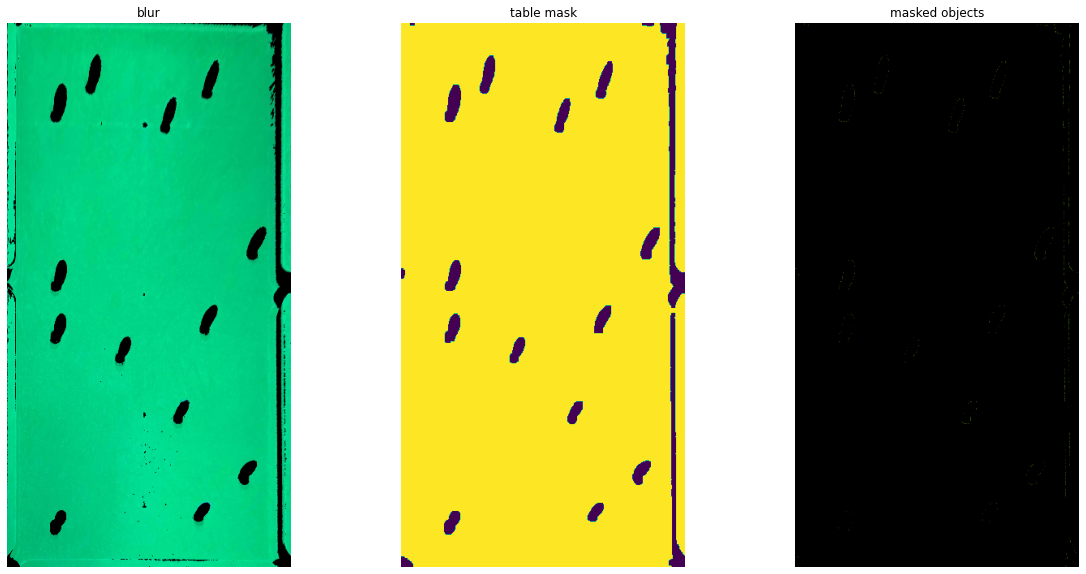

In [62]:
transformed_blur = cv2.GaussianBlur(dst_green,(0,0),0.005) # blur applied
blur_RGB = cv2.cvtColor(transformed_blur, cv2.COLOR_BGR2RGB) # rgb version

# hsv colors of the snooker table
lower = np.array([40, 180, 100])
upper = np.array([100, 255, 255])

hsv = cv2.cvtColor(blur_RGB, cv2.COLOR_RGB2HSV) # convert to hsv
mask = cv2.inRange(hsv, lower, upper) # table's mask

# apply closing
kernel = np.ones((5,5),np.uint8)
mask_closing = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel) # dilate->erode

# invert mask to focus on objects on table
_,mask_inv = cv2.threshold(mask_closing,5,255,cv2.THRESH_BINARY_INV) # mask inv

masked_img = cv2.bitwise_and(dst_green,dst_green, mask=mask_inv) # masked image with inverted mask



# plot edges, threshold, filter
plt.figure(figsize=(20,10))
plt.subplot(1,3,1)
plt.imshow(blur_RGB)
plt.title('blur')
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(mask_closing)
plt.title('table mask')
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(masked_img) 
plt.title('masked objects')
plt.axis('off')
plt.show()

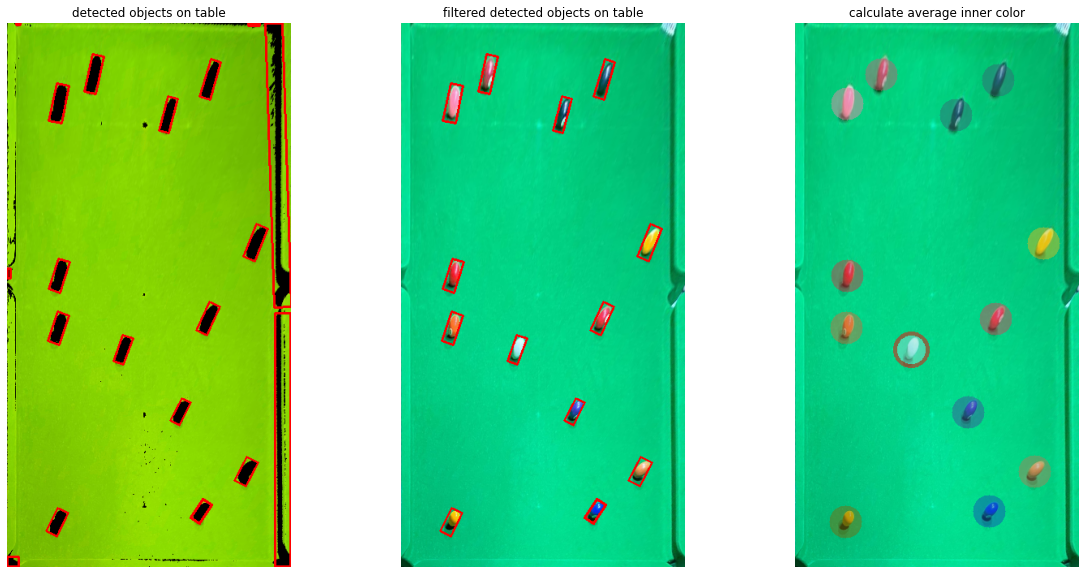

In [63]:
# find contours and filter them
ctrs, hierarchy = cv2.findContours(mask_inv, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE) # create contours in filtered img

# draw contours before filter
detected_objects = draw_rectangles(ctrs, dst_green) # detected objects will be marked in boxes

ctrs_filtered = filter_ctrs(ctrs, dst_img) # filter unwanted contours (wrong size or shape)

# draw contours after filter
detected_objects_filtered = draw_rectangles(ctrs_filtered, dst_img) # filtered detected objects will be marked in boxes

# find average color inside contours:
ctrs_color, white_ball_coors = find_ctrs_color(ctrs_filtered, dst_img)
ctrs_color = cv2.addWeighted(ctrs_color,0.5,dst_img,0.5,0) # contours color image + transformed image

# plot results
plt.figure(figsize=(20,10))
plt.subplot(1,3,1)
plt.imshow(detected_objects)
plt.title('detected objects on table')
plt.axis('off')
#cv2.imwrite(rawname + '3.jpg',  cv2.cvtColor(detected_objects, cv2.COLOR_BGR2RGB))

plt.subplot(1,3,2)
plt.imshow(detected_objects_filtered)
plt.title('filtered detected objects on table')
plt.axis('off')
#cv2.imwrite(rawname + '4.jpg',  cv2.cvtColor(detected_objects_filtered, cv2.COLOR_BGR2RGB))

plt.subplot(1,3,3)
plt.imshow(ctrs_color)
plt.title('calculate average inner color')
plt.axis('off')
plt.show()
#cv2.imwrite(rawname + '5.jpg',  cv2.cvtColor(ctrs_color, cv2.COLOR_BGR2RGB))

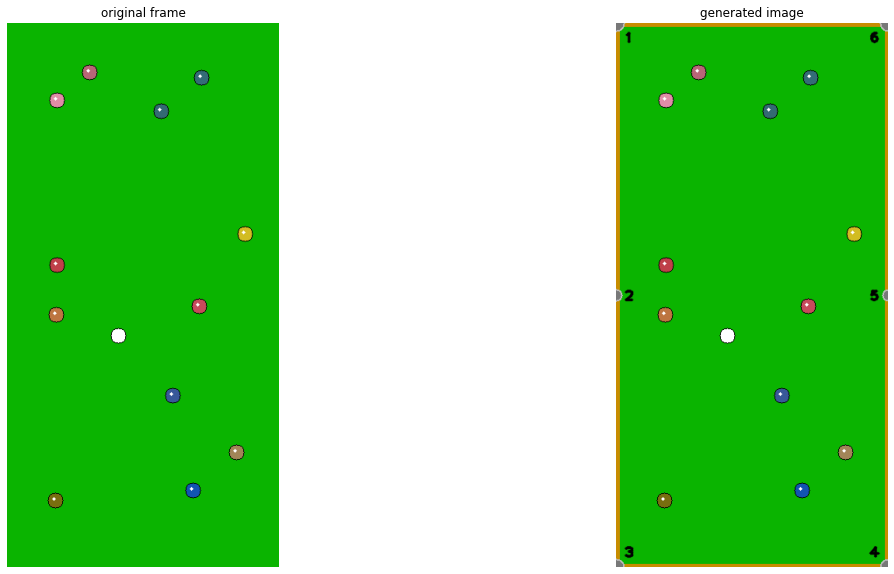

In [64]:
# design of the 2D generated table

lim = 5

final, balls = draw_balls(ctrs_filtered, white_ball_coors, img=dst_img) # gets contours and draws balls in their centers
frame = draw_holes(final) # draws holes in the 2D img
holes = [[0, 0], [0, int(height / 2)], [0, height], [width, height], [width, int(height / 2)], [width, 0]]
holes = list(zip(range(1,7), holes))

font = cv2.FONT_HERSHEY_PLAIN
holes_coors = [(10, 25), (10, 357), (10, 687), (326, 687), (326, 357), (326, 25)]
fontScale = 1.25
color = (0, 0, 0)
thickness = 2

for number, hole in zip(range(1,len(holes_coors)+1), holes_coors):
    image = cv2.putText(frame, str(number), hole, font, fontScale, color, thickness, cv2.LINE_AA)

plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(final)
plt.title('original frame')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(frame)
plt.title('generated image')
plt.axis('off')
plt.show()
#cv2.imwrite(rawname + '6.jpg',  cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

In [65]:
clear_hole_path = []
board_copy = final.copy()#making copy
board_copy = cv2.circle(board_copy, white_ball_coors, ball_radius+1, certain_green, -1)#erasing the white ball

for x in product(balls, holes):
    x = list(x)
    ball_center, hole = x
    hole_coors = hole[1]
    hole_vector = [hole_coors[0]-ball_center[0], hole_coors[1]-ball_center[1]]

    white_ball_vector = [white_ball_coors[0]-ball_center[0], white_ball_coors[1]-ball_center[1]]

    angle = angle_between(hole_vector, white_ball_vector)

    if angle < 110:
        continue    
    line_mask = np.zeros(board_copy.shape[:2], np.uint8)
    ball_color = [x for x in board_copy[ball_center[1]][ball_center[0]]]
    board_copy = cv2.circle(board_copy, ball_center, ball_radius+1, certain_green, -1)#erasing the current ball
    cv2.line(line_mask, ball_center, hole[1], 1, ball_radius*2)#drawing the hole-line
    cv2.line(line_mask, ball_center, white_ball_coors, 1, ball_radius*2)#drawing the white ball-line
    masked = cv2.bitwise_and(board_copy, board_copy, mask=line_mask)
    masked_flattned = masked.flatten()
    masked_flattned = masked_flattned.reshape((len(masked_flattned)//3, 3))
    black_pixel = np.array([0,0,0])
    non_zero = [list(x) for x in masked_flattned if not np.array_equal(x, black_pixel)]
    non_green = [x for x in non_zero if (x != certain_green_bgr and x!=certain_green)]

    if len(non_green) == 0:
        hole_distance = np.linalg.norm(white_ball_vector)
        white_ball_distance = np.linalg.norm(hole_vector)
        parameters = (white_ball_distance, hole_distance, angle)
        x.append(parameters)
        clear_hole_path.append(x)
        
    #drawing back the target ball
    board_copy = cv2.circle(board_copy,  # img to draw on
                       ball_center,  # position on img
                       ball_radius,  # radius of circle - size of drawn snooker ball
                       [29, 51, 33],
                       # color mean of each contour-color of each ball (src_img=transformed img)
                       -1)  # -1 to fill ball with color
    # add black color around the drawn ball (for cosmetics)
    board_copy = cv2.circle(board_copy, ball_center, ball_radius, 0, 1)
    # small circle for light reflection
    board_copy = cv2.circle(board_copy, (ball_center[0] - 2, ball_center[1] - 2), 2, (255, 255, 255), -1)
    
# drawing back the white ball
final = cv2.circle(board_copy,  # img to draw on
                   white_ball_coors,  # position on img
                   ball_radius,  # radius of circle - size of drawn snooker ball
                   (255,255,255),
                   # color mean of each contour-color of each ball (src_img=transformed img)
                   -1)  # -1 to fill ball with color
final = cv2.circle(board_copy, white_ball_coors, ball_radius, 0, 1)

    
clear_hole_path.sort(key=lambda x: x[2])
    

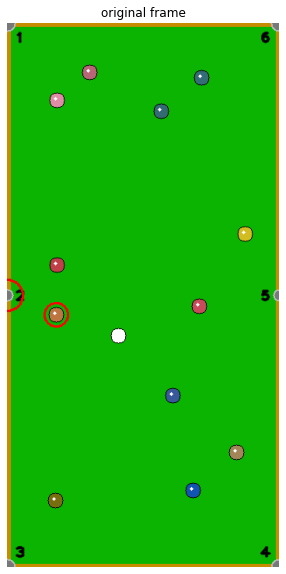

In [66]:
anglesort = enumerate(sorted(clear_hole_path, key=lambda x: abs(180-x[2][2])))

distancesort = enumerate(sorted(anglesort, key=lambda x: x[1][2][0]+x[1][2][1]))

finalsort = sorted(distancesort, key=lambda x: x[0]+x[1][0])
    
frame_copy = frame.copy()
ball_coor, hole, parameters = finalsort[0][1][1]
frame_copy = cv2.circle(frame_copy, ball_coor, ball_radius+5, (255,0,0), 2)
frame_copy = cv2.circle(frame_copy, hole[1], 20, (255,0,0), 2)

plt.figure(figsize=(20,10))
plt.subplot(1,1,1)
plt.imshow(frame_copy)
plt.title('original frame')
plt.axis('off')
#cv2.imwrite(rawname + '7.jpg',  cv2.cvtColor(frame_copy, cv2.COLOR_BGR2RGB))

frame_copy = None